In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt  
import numpy as np  
import tensorflow as tf
import pandas as pd
from keras.src.callbacks import LambdaCallback
from keras.layers import Dense
from keras.models import Model
import torch
import keras

In [ ]:
# from imblearn.over_sampling import SMOTE
# 
# #不均衡采样
# def smote(X_train, y_train):
#     # Create an instance of SMOTE
#     smote = SMOTE(random_state=10)
#     # Apply SMOTE to the training data
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#     return X_train_resampled, y_train_resampled

In [29]:
 # 加载训练集和测试集 
# X_train = pd.read_csv(r"data/X_train_minmaxscaler.csv")['ChatGPT回答'].iloc[:10]
# X_test = pd.read_csv(r"data/X_test_minmaxscaler.csv")['ChatGPT回答'].iloc[:10]
y_train = pd.read_csv(r"data/y_train_minmaxscaler.csv")
y_test = pd.read_csv(r"data/y_test_minmaxscaler.csv")

In [30]:
# 构建词向量
X_train_embedding = torch.load('data_embedding/train_embedding.pt',map_location=torch.device('cpu'))
X_test_embedding = torch.load('data_embedding/test_embedding.pt',map_location=torch.device('cpu'))

In [ ]:
#smote采样
# X_train_embedding, y_train = smote(X_train_embedding.numpy(), y_train)
# X_test_embedding, y_test = smote(X_test_embedding.numpy(), y_test)

In [54]:
#构建模型  
from tensorflow.python.keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):  

    # print(f'Epoch {epoch + 1}, Loss: {logs["loss"]}') 
    print(f'Epoch {epoch + 1}') 
    train_loss = logs.get('loss')  
    val_loss = logs.get('val_loss')  
    train_acc = logs.get('accuracy')  
    val_acc = logs.get('val_accuracy')  
      
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '  
          f'Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')  
    print("\n")

def bert_model(X_train, y_train,num_epochs):
# Create a sequential model
#输入为（n，512，768）
    # 定义输入层
    input_layer = keras.layers.Input(shape=(768,))
    # flatten_layer = tf.keras.layers.Flatten()(input_layer)
    # 添加全连接层
    dense_output1 = Dense(128, activation='relu')(input_layer)
    # dense_output2 = Dense(128, activation='relu')(dense_output1)
    dense_output3 = Dense(64, activation='relu')(dense_output1)
    output= Dense(1, activation='sigmoid')(dense_output3)
    model = Model(inputs=input_layer, outputs=output)

    optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=1e-6) 
# Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    callback = LambdaCallback(on_epoch_end=on_epoch_end) 
    # Fit the model to the data
    def_history=model.fit(X_train.numpy(), y_train,validation_split=0.3, epochs=num_epochs, batch_size=32,callbacks=[callback])
    #每10个epoch打印一次loss和accu

    return model, def_history

In [55]:
# 模型训练
bert_bp_model,history = bert_model(X_train_embedding, y_train, num_epochs=32)

Epoch 1/32
3382/3382 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.7927Epoch 1
Epoch 1, Loss: 0.1435, Val Loss: 0.1388, Acc: 0.7927, Val Acc: 0.8007


3382/3382 [==============================] - 22s 6ms/step - loss: 0.1435 - accuracy: 0.7927 - val_loss: 0.1388 - val_accuracy: 0.8007
Epoch 2/32
3381/3382 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.8021Epoch 2
Epoch 2, Loss: 0.1376, Val Loss: 0.1365, Acc: 0.8022, Val Acc: 0.8042


3382/3382 [==============================] - 21s 6ms/step - loss: 0.1376 - accuracy: 0.8022 - val_loss: 0.1365 - val_accuracy: 0.8042
Epoch 3/32
3371/3382 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.8043Epoch 3
Epoch 3, Loss: 0.1356, Val Loss: 0.1364, Acc: 0.8042, Val Acc: 0.8020


3382/3382 [==============================] - 17s 5ms/step - loss: 0.1356 - accuracy: 0.8042 - val_loss: 0.1364 - val_accuracy: 0.8020
Epoch 4/32
3370/3382 [============================>.] - ETA: 0s - l

In [47]:
# 评估模型
score = bert_bp_model.evaluate(X_test_embedding.numpy(), y_test, verbose=0)  
print('Test loss:', score[0])  
print('Test accuracy:', score[1])

Test loss: 0.1428508162498474
Test accuracy: 0.8002069592475891


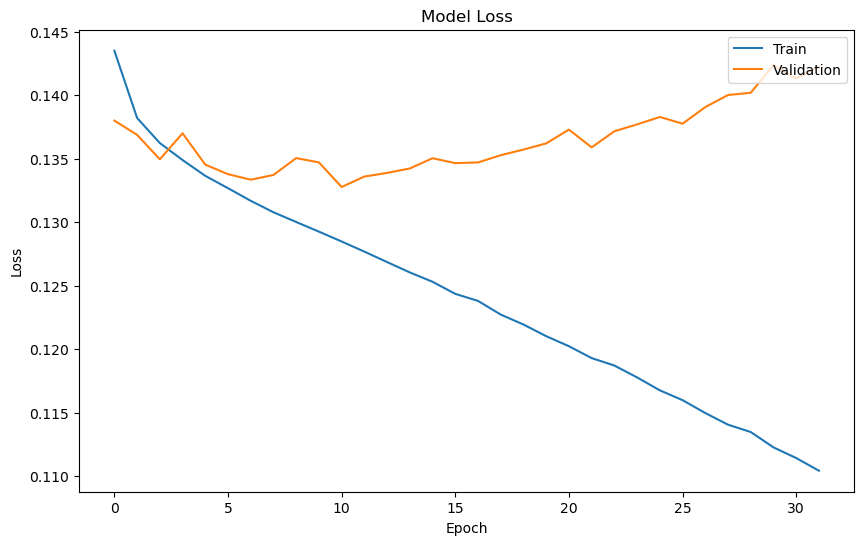

In [48]:
#绘制loss曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig('bert_bp_loss.png')
plt.show()

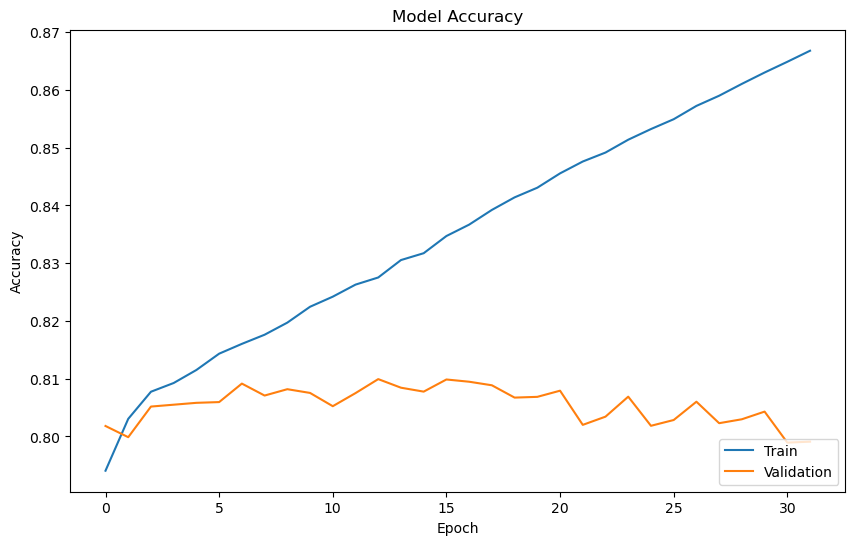

In [38]:
#绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
# plt.savefig('bert_bp_accuracy.png')
plt.show()

In [ ]:
#使用tensorflow保存模型
bert_bp_model.save('bert_bp_model.h5')

In [51]:
#模型的评价
def evaluate_bert_bp_model(model, X_test, y_test):
    
    # Predict probabilities
    y_pred_proba = model.predict(X_test)
    
    # Predict labels
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(model.predict(X_test),axis=1)
    y_pred=np.where(y_pred_proba>0.5,1,0)
    # Calculate accuracy, precision, recall, F1-score, and AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    return [accuracy, precision, recall, f1, auc,fpr.tolist(), tpr.tolist()]

In [52]:
import json
#计算每个模型的评价指标,
metrics_name = ['accuracy', 'precision', 'recall', 'f1-score','auc','fpr-score','tpr-score']
#计算每个模型的评价指标值，然后按照模型名，指标名称将结果存入一个字典
metrics = evaluate_bert_bp_model(bert_bp_model, X_test_embedding.numpy(), y_test)
bert_metrics_dict = {metrics_name[j]: metrics[j] for j in range(len(metrics))}

1208/1208 [==============================] - 4s 3ms/step


In [53]:
print(bert_metrics_dict)

{'accuracy': 0.8002069857697284, 'precision': 0.5956346927053418, 'recall': 0.45814004859730506, 'f1-score': 0.5179173429891373, 'auc': 0.8043214728388689, 'fpr-score': [0.0, 0.0, 0.0, 3.378834977699689e-05, 3.378834977699689e-05, 6.757669955399378e-05, 6.757669955399378e-05, 0.00010136504933099067, 0.00010136504933099067, 0.00013515339910798757, 0.00013515339910798757, 0.00016894174888498447, 0.00016894174888498447, 0.00020273009866198134, 0.00020273009866198134, 0.00023651844843897824, 0.00023651844843897824, 0.00027030679821597514, 0.00027030679821597514, 0.00030409514799297204, 0.00030409514799297204, 0.00033788349776996894, 0.00033788349776996894, 0.0003716718475469658, 0.0003716718475469658, 0.0004054601973239627, 0.0004054601973239627, 0.0004392485471009596, 0.0004392485471009596, 0.0004730368968779565, 0.0004730368968779565, 0.0005406135964319503, 0.0005406135964319503, 0.0005744019462089471, 0.0005744019462089471, 0.0006081902959859441, 0.0006081902959859441, 0.000641978645762

In [ ]:
#以json文件保存字典结果
with open('bert_bp_metrics_dict.json', 'w') as f:
    json.dump(bert_metrics_dict, f)